# Visualization of MRI data with labels

In [2]:
# import
import os
import numpy as np

import nibabel as nib
from nibabel.testing import data_path

import matplotlib.pyplot as plt

## Dataset visualization

In [3]:
mri_1 = nib.load('MRI/00001.nii')
mri_1_data = mri_1.get_fdata()
mri_1_data.shape

(606, 864, 61)

In [4]:
def show(slices, size, col=5, cmap=None, aspect=6):
   rows = -(-len(slices)//col)
   fig, axes = plt.subplots(rows, col, figsize=(15,2*rows))
   # Flatten the axes array to simplify indexing
   axes = axes.flatten()
   for i, slice in enumerate(slices):
       axes[i].imshow(slice.T, cmap=cmap, origin="lower", aspect=aspect)
       axes[i].set_title(f'Slice {size - i*5}')  # Set titles if desired
   # Adjust layout to prevent overlap of titles
   plt.tight_layout()

In [5]:
def show_slices(data, end, lap, col=5, cmap=None, aspect=6):
   """ Function to display row of image slices """
   it = 0
   slices = []
   for slice in range(data.shape[1]-1, 0, -lap):
       it += 1
       slices.append(data[:, slice, :])
       if it==end: break
   show(slices, data.shape[1], col, cmap, aspect)
    

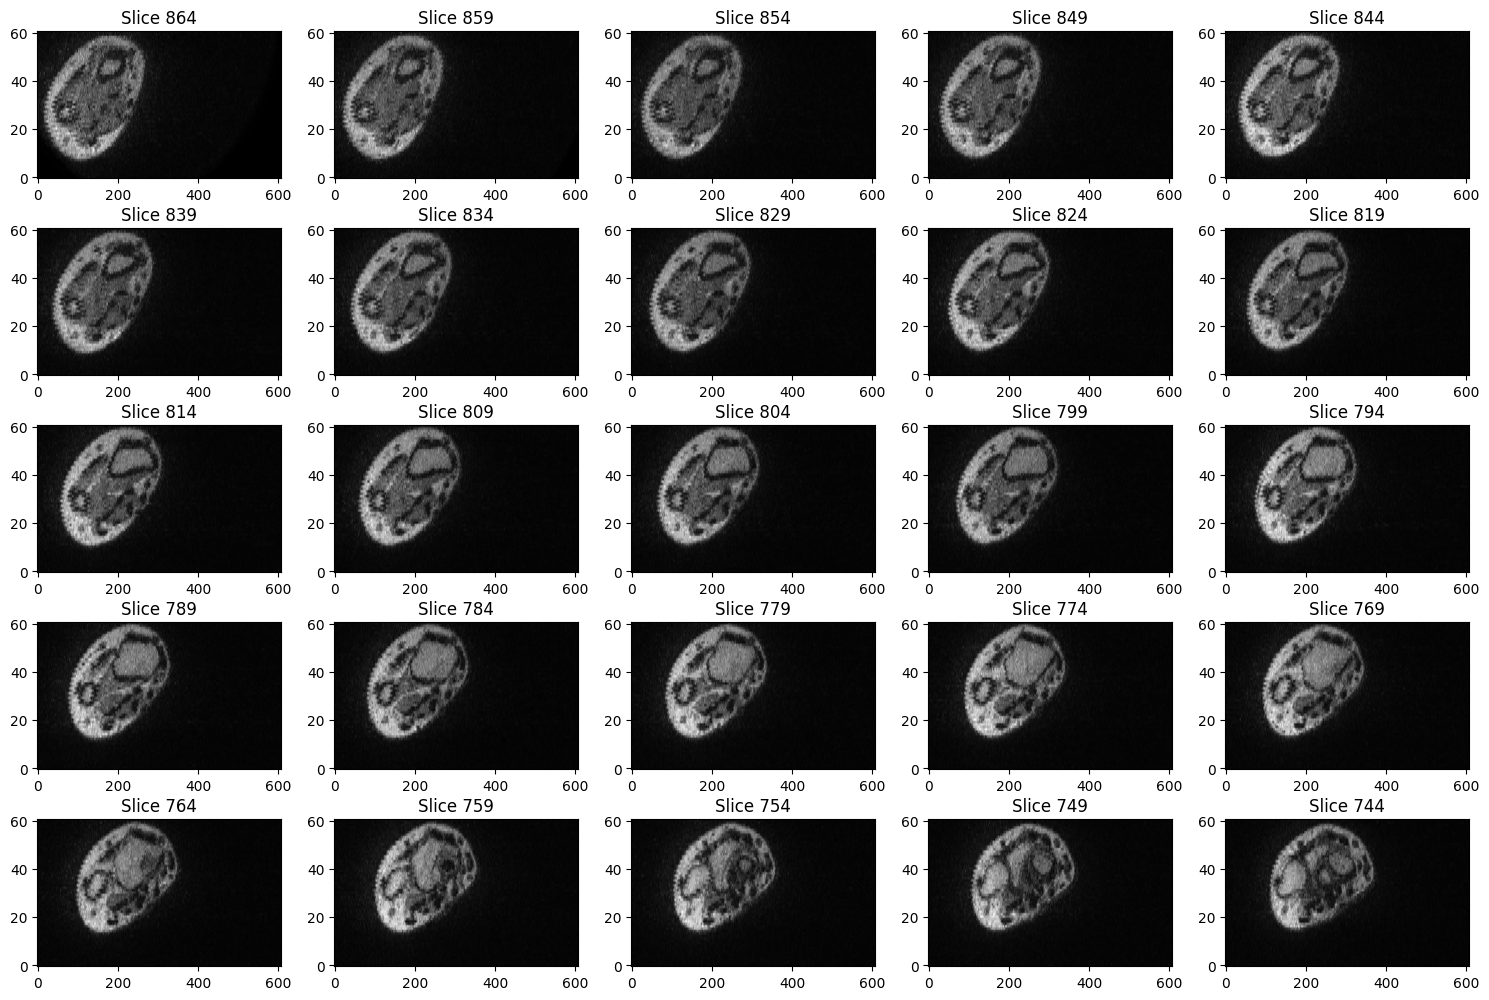

In [6]:
show_slices(mri_1_data, 25, 5, cmap="gray")

## Affine Matrix

In [7]:
from nibabel.affines import apply_affine

mri_vox_center = (np.array(mri_1_data.shape) - 1) / 2.

print("MRI vox center bf trans: ", mri_vox_center)
print("MRI affine: \n", mri_1.affine)

transf_voxel = apply_affine(mri_1.affine, mri_vox_center)
print("Vox center after trans: ", transf_voxel)

MRI vox center bf trans:  [302.5 431.5  30. ]
MRI affine: 
 [[-2.32137202e-01 -7.18467707e-10 -3.47903158e-01  8.66145706e+01]
 [ 8.61425497e-02  1.29008130e-10 -9.37530476e-01  4.90137558e+01]
 [ 7.18467707e-10 -2.47604966e-01  5.21024002e-10  1.00304581e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Vox center after trans:  [ 5.95597206 46.94596286 -6.53696198]


Visualizing the transformation in ImFusion gives no reasonable results.

### S-form affine

In [8]:
header = mri_1.header
print("sform: ", header.get_sform())
print(mri_1.get_sform(coded=True))
print("Sform code: ", mri_1.header['sform_code'])

sform:  [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 1.]]
(None, 0)
Sform code:  0


The s-affine is not valid, since the sform_code = 0 
<div style="text-align:center">
  <img src="img/sform_code_table.png" alt="Your Image Description">
</div>

### Q-form affine
Since the s-form affine is not valid, we try the q-form afifne.

This affine can be calculated from a combination of the voxel sizes (entries 1 through 4 of the pixdim field), a sign flip called qfac stored in entry 0 of pixdim, and a quaternion that can be reconstructed from fields quatern_b, quatern_c, quatern_d.

In [9]:
print("Q_form affine: \n", mri_1.get_qform(coded=True))
print("qform code: ", mri_1.header['qform_code'])

Q_form affine: 
 (array([[-2.32137202e-01, -7.18467707e-10, -3.47903158e-01,
         8.66145706e+01],
       [ 8.61425497e-02,  1.29008130e-10, -9.37530476e-01,
         4.90137558e+01],
       [ 7.18467707e-10, -2.47604966e-01,  5.21024002e-10,
         1.00304581e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]]), 1)
qform code:  1


## Label dataset

In [10]:
mri_1_label = nib.load('MRI/Labels/final/LabelsDani.nii')
mri_1_label_data = mri_1_label.get_fdata()
mri_1_label_data.shape

(606, 864, 61)

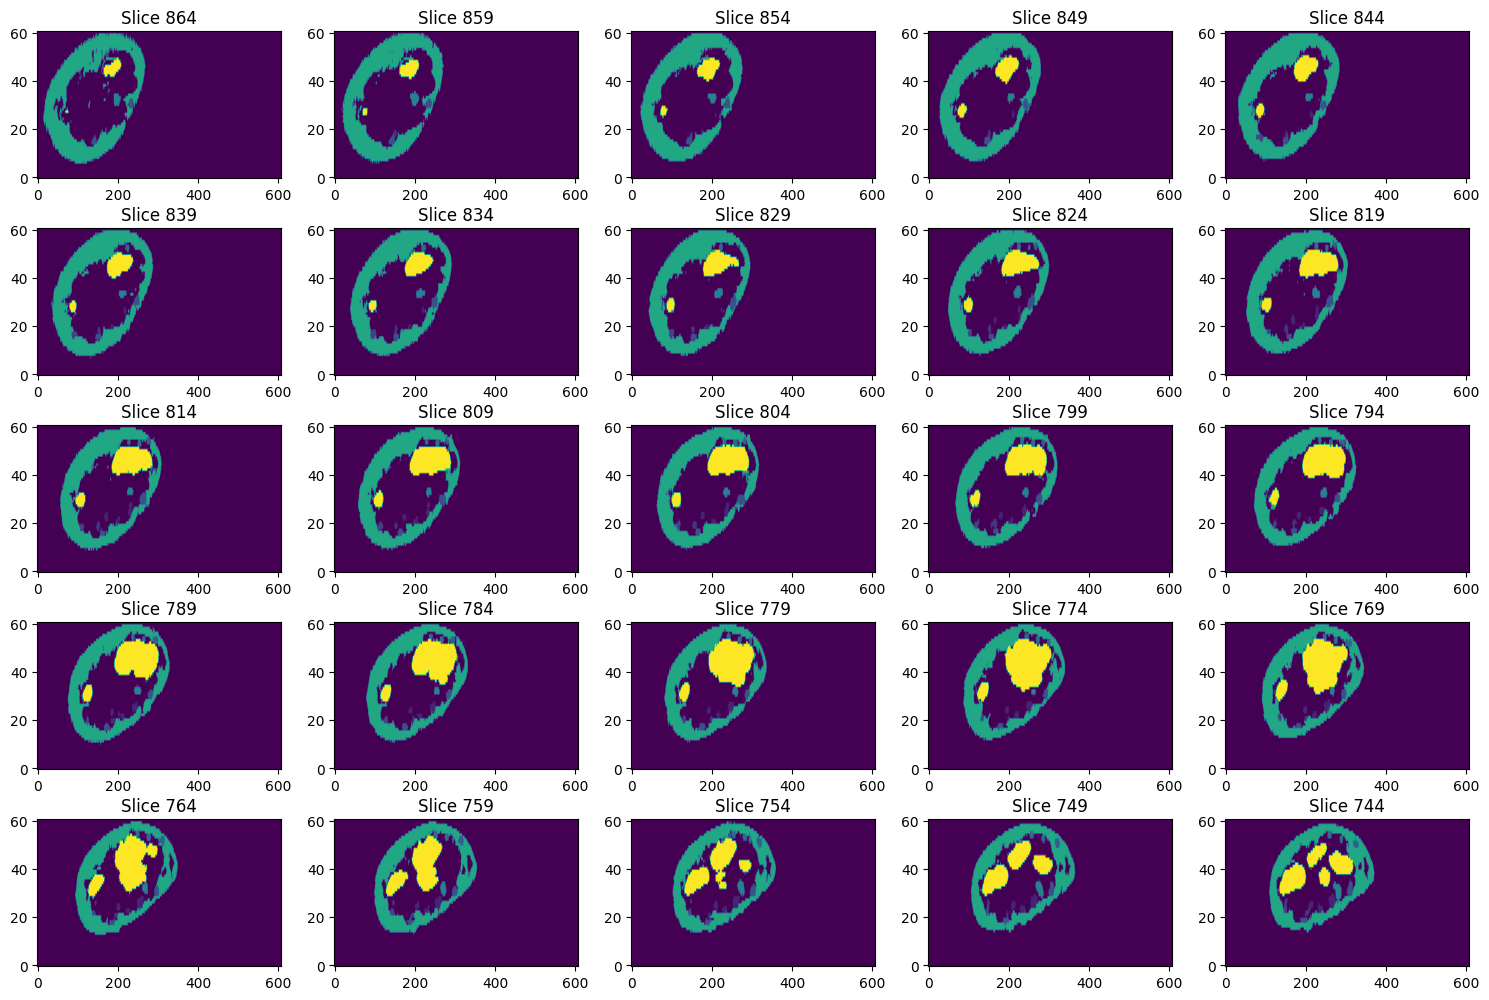

In [11]:
show_slices(mri_1_label_data, 25, 5)

In [12]:
print("Mri label data: \n", np.max(mri_1_label_data))
print("Mri data: \n", np.max(mri_1_data))


Mri label data: 
 20.0
Mri data: 
 693.0


## Affine Transformations
Let's try transforming the visualizaiton of the slices.

The optimal view has been manually selected on ImFusion. The transformation matrix has then be extracted from the program and can be used to transform the visualization of the slices in the same way.

In [13]:
imFusion_trans_og = \
[[   0.915608359793373,   -0.333254189335102,    0.224951054158662,                  -10],
 [    0.21138484580494,  -0.0769377913064519,   -0.974370064827993,                 -6.5],
 [   0.342020143325669,    0.939692620785908, 5.22225573892876e-10,                   47],
 [                   0,                    0,                    0,                    1]]



affine_trans = \
[[-2.32137202e-01, -7.18467707e-10, -3.47903158e-01,  8.66145706e+01],
 [ 8.61425497e-02,  1.29008130e-10, -9.37530476e-01,  4.90137558e+01],
 [ 7.18467707e-10, -2.47604966e-01,  5.21024002e-10,  1.00304581e+02],
 [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]

In [14]:
imFusion_trans_og = np.array(imFusion_trans_og)
print("ImFusion oprimal transf: \n", imFusion_trans_og)
mri_1_label_affine = mri_1_label.affine
print("Affine matrix: \n", mri_1_label_affine)

ImFusion oprimal transf: 
 [[ 9.15608360e-01 -3.33254189e-01  2.24951054e-01 -1.00000000e+01]
 [ 2.11384846e-01 -7.69377913e-02 -9.74370065e-01 -6.50000000e+00]
 [ 3.42020143e-01  9.39692621e-01  5.22225574e-10  4.70000000e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Affine matrix: 
 [[-2.32137203e-01 -7.18467785e-10 -3.47903162e-01  8.66145706e+01]
 [ 8.61425474e-02  1.29008124e-10 -9.37530458e-01  4.90137558e+01]
 [ 7.18467785e-10 -2.47604966e-01  5.21024002e-10  1.00304581e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


A simpler transformation is used for testing

In [15]:
trans = \
[[0, 0, -1, 0],
 [0, 1, 0, 0],
 [1, 0, 0, 0],
 [0, 0, 0, 1]]
trans = np.array(trans)
print(trans)

[[ 0  0 -1  0]
 [ 0  1  0  0]
 [ 1  0  0  0]
 [ 0  0  0  1]]


### Transform using affine multiplication

In [16]:
# Apply the transformation to the affine matrix
custom_affine = np.dot(trans, mri_1_label_affine)
print(custom_affine)

# Create a new nibabel image with the transformed affine matrix
transformed_img = nib.Nifti1Image(mri_1_label_data, custom_affine)
transformed_img_data = transformed_img.get_fdata()
print(np.max(transformed_img_data))


[[-7.18467785e-10  2.47604966e-01 -5.21024002e-10 -1.00304581e+02]
 [ 8.61425474e-02  1.29008124e-10 -9.37530458e-01  4.90137558e+01]
 [-2.32137203e-01 -7.18467785e-10 -3.47903162e-01  8.66145706e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
20.0


In [17]:
print(nib.aff2axcodes(mri_1_label.affine))
print(nib.aff2axcodes(transformed_img.affine))

('L', 'I', 'P')
('I', 'R', 'P')


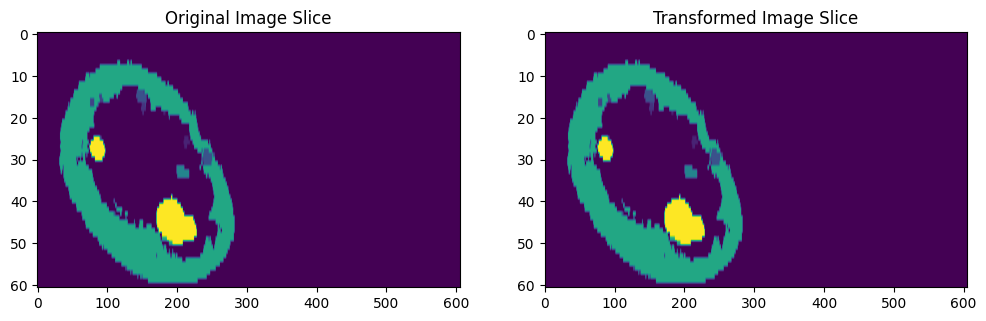

In [18]:
# Display the original and transformed images (slices)
original_slice = mri_1_label_data[:, mri_1_label_data.shape[1]-20, :]
transformed_slice = transformed_img_data[:, transformed_img.shape[1]-20, :]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(original_slice.T, aspect=6)
plt.title('Original Image Slice')

plt.subplot(1, 2, 2)
plt.imshow(transformed_slice.T, aspect=6)
plt.title('Transformed Image Slice')

plt.show()

This is not working since the affine transformation is only transforming the img CS in relation the the world CS. 

Images are however taken always the same way slicing the array represented in the img CS, so the two slices are the same.

Next, I try to define a slice in world CS.

In [19]:
first_slice_world_coordinates = np.dot(custom_affine, np.append((605, 863, 60), 1))[:3]

print(f"World coordinates of the first y-slice: {first_slice_world_coordinates}")

World coordinates of the first y-slice: [113.37850464  44.87816963 -74.70262768]


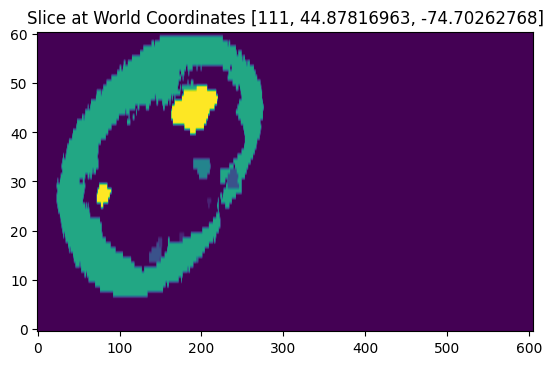

In [20]:
# Define the world coordinates you want to slice at
world_coordinates = [111,  44.87816963, -74.70262768]  # Replace with your desired world coordinates

# Convert world coordinates to voxel coordinates
voxel_coordinates = (np.linalg.solve(custom_affine, np.append(world_coordinates, 1)))[:3].astype(int)

# Extract the slice from the image data using voxel coordinates
slice_data = transformed_img.get_fdata()[:, voxel_coordinates[1], :]

# Display the slice
plt.imshow(slice_data.T, origin='lower', aspect=6)
plt.title(f'Slice at World Coordinates {world_coordinates}')
plt.show()

In [21]:
voxel_coordinates

array([605, 853,  59])

This is also not working, since transforming back to voxel space still gives a slice in img CS.

Next I try transforming the image itself by 90 deg.

## Image transformation

In [22]:
rotated_data = np.rot90(mri_1_label_data, k=1, axes=(0, 2))
rotated_img = nib.Nifti1Image(rotated_data, mri_1_label_affine)
nib.save(rotated_img, 'path_to_save_rotated_volume.nii')

# Display the original and transformed images (slices)
# original_slice = mri_1_label_data[:, mri_1_label_data.shape[1]-20, :]
# transformed_slice = rotated_img.get_fdata()[:, rotated_img.shape[1]-20, :]

# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.imshow(original_slice.T, aspect=6)
# plt.title('Original Image Slice')

# plt.subplot(1, 2, 2)
# plt.imshow(transformed_slice.T, aspect=1/6)
# plt.title('Transformed Image Slice')

# plt.show()


In [23]:
custom_affine = np.array([[ 0.66446302,  0.03603338,  0.74645193,  0.        ],
                            [ 0.24184476,  0.93472006, -0.2604026 ,  0.        ],
                            [-0.70710678,  0.35355339,  0.61237244,  0.        ],
                            [ 0.        ,  0.        ,  0.        ,  1.        ]])

rotated_img_custom = nib.Nifti1Image(rotated_data, custom_affine)
nib.save(rotated_img_custom, 'path_to_save_rotated_volume_custom.nii.gz')

This seems working.

Let's try to apply the transformation voxel for voxel!

### Padding
In order to have enough space to apply the rotation in all dimension, padding might be useful

In [22]:
def padding(original_array):
    # Find the maximum dimension
    max_dim = max(original_array.shape)

    # Calculate padding for each dimension (left and right)
    padding_x_left = (max_dim - original_array.shape[0]) // 2
    padding_x_right = max_dim - original_array.shape[0] - padding_x_left

    padding_y_left = (max_dim - original_array.shape[1]) // 2
    padding_y_right = max_dim - original_array.shape[1] - padding_y_left

    padding_z_left = (max_dim - original_array.shape[2]) // 2
    padding_z_right = max_dim - original_array.shape[2] - padding_z_left

    # Pad the array with zeros
    padded_array = np.pad(original_array, ((padding_x_left, padding_x_right), 
                                        (padding_y_left, padding_y_right), 
                                        (padding_z_left, padding_z_right)), 
                        mode='constant')

    # Verify the shapes
    print("Original Array Shape:", original_array.shape)
    print("Padded Array Shape:", padded_array.shape)

    return padded_array

In [23]:
padded_array = padding(mri_1_label_data)

Original Array Shape: (606, 864, 61)
Padded Array Shape: (864, 864, 864)


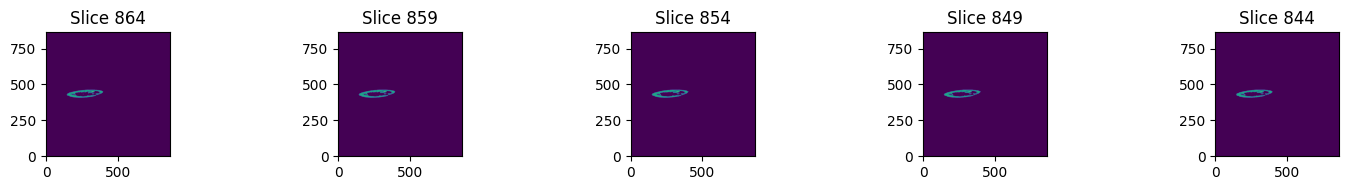

In [24]:
np.max(padded_array)
show_slices(padded_array, 5, 1, aspect=1)

### Regular Grid Interpolation
In the following I tried out a tutorial that uses RegularGridInterpolatin, which can be found [here](https://medium.com/vitrox-publication/rotation-of-voxels-in-3d-space-using-python-c3b2fc0afda1).

Voxel is a 3D equivalent of a pixel in a 2D image (VOlume piXEL). The data is represented by a 3D array where the value of a specific element (voxel) in the array represents some physical properties (color, density) in the space.

The rotational operation for 3D volumetric data encoded in these 2 formats can be easily achieved by multiplying a rotational matrix to the coordinates of the points. However, the rotation matrix cannot work directly on voxel data as the data are not representing coordinates. However, the coordinate of a voxel is derived from its relative position in the 3D array, a coordinate system can be constructed and the rotation can be performed by rotating the coordinate system in the opposite direction.

For 3D volumetric data consisting of voxels (or 3D array), the rotation operation can only be achieved through ndimage module of the SciPy package 

In [25]:
from scipy.interpolate import RegularGridInterpolator

trans_mat_inv = trans[:3, :3]
image = padded_array
print(image.shape)

# def img_rotation(trans_mat_inv, image):
# Construct the coordinate (𝑥𝑖,𝑦𝑖,𝑧𝑖) for all the voxels with mesh grid from NumPy.
Nz, Ny, Nx = image.shape
x = np.linspace(0, Nx - 1, Nx)
y = np.linspace(0, Ny - 1, Ny)
z = np.linspace(0, Nz - 1, Nz)

(864, 864, 864)


In [26]:
zz, yy, xx = np.meshgrid(z, y, x, indexing='ij')
mri_vox_center = (np.array(mri_1_data.shape) - 1) // 2
x_center, y_center, z_center = mri_vox_center
mri_vox_center
coor = np.array([xx - x_center, yy - y_center, zz - z_center])

: 

In [1]:
# Evaluate the new coordinate (𝑥𝑖′,𝑦𝑖′,𝑧𝑖′) by multiplying matrix 𝑀−1 to the original coordinate (𝑥𝑖,𝑦𝑖,𝑧𝑖).
coor_prime = np.tensordot(trans_mat_inv, coor, axes=((1), (0)))
print(coor_prime.shape)
xx_prime = coor_prime[0] + x_center
yy_prime = coor_prime[1] + y_center
zz_prime = coor_prime[2] + z_center

# Identify the set of points (voxels) that require interpolation, 
# eliminate the points with new coordinates which lie beyond the region bounded by the cuboid of the original volume, 
# i.e. 𝑥′𝑖∉{𝑝|0≤𝑝≤𝑁𝑥−1}，𝑦′𝑖∉{𝑝|0≤𝑝≤𝑁𝑦−1}，𝑧′𝑖∉{𝑝|0≤𝑝≤𝑁𝑧−1}.
x_valid1 = xx_prime>=0
x_valid2 = xx_prime<=Nx-1
y_valid1 = yy_prime>=0
y_valid2 = yy_prime<=Ny-1
z_valid1 = zz_prime>=0
z_valid2 = zz_prime<=Nz-1
valid_voxel = x_valid1 * x_valid2 * y_valid1 * y_valid2 * z_valid1 * z_valid2
z_valid_idx, y_valid_idx, x_valid_idx = np.where(valid_voxel > 0)

# Initialize a 3D array with size the same as the original 3D array (use for storing transformed results).
image_transformed = np.zeros((Nz, Ny, Nx))

# Interpolate using the function scipy.interpolate.RegularGridInterpolator(), return the values to the transformed array according to their respective indices.
data_w_coor = RegularGridInterpolator((z, y, x), image)
interp_points = np.array([zz_prime[z_valid_idx, y_valid_idx, x_valid_idx],
                          yy_prime[z_valid_idx, y_valid_idx, x_valid_idx],
                          xx_prime[z_valid_idx, y_valid_idx, x_valid_idx]]).T
interp_result = data_w_coor(interp_points)
image_transformed[z_valid_idx, y_valid_idx, x_valid_idx] = interp_result

NameError: name 'np' is not defined

In [ ]:
print(np.max(image_transformed))
show_slices(image_transformed, 15, 5)

### Scipy affine transform


In [25]:
padded_array[0].ravel().shape

(746496,)

In [26]:
from scipy.ndimage import affine_transform

# Your 4x4 transformation matrix
transformation_matrix = trans
print("Transformation: \n", transformation_matrix[:3,:3])

# Your original 3D array
original_array = mri_1_label_data

# Create a grid of coordinates for each voxel in the original array
x, y, z = np.meshgrid(np.arange(original_array.shape[0]),
                      np.arange(original_array.shape[1]),
                      np.arange(original_array.shape[2]), indexing='ij')
print("Creating a meshgrid to transform each coordinate: \n", x.shape,  y.shape, z.shape)

# Reshape the coordinates to a 2D array for matrix multiplication
coordinates = np.vstack((x.ravel(), y.ravel(), z.ravel(), np.ones_like(x.ravel())))
print("Flattened coordinate meshgrid, adding a row for ones: \n", coordinates.shape)

Transformation:  [[ 0  0 -1]
 [ 0  1  0]
 [ 1  0  0]]
Creating a meshgrid to transform each coordinate: 
 (606, 864, 61) (606, 864, 61) (606, 864, 61)
Flattened coordinate meshgrid, adding a row for ones: 
 [[  0   0   0 ... 605 605 605]
 [  0   0   0 ... 863 863 863]
 [  0   1   2 ...  58  59  60]
 [  1   1   1 ...   1   1   1]]
Shape: 
 (4, 31938624)


In [31]:
padded_array[:].shape

(864, 864)

In [27]:
flat = np.vstack((padded_array[0].ravel(), padded_array[1].ravel(), padded_array[2].ravel(), np.ones_like(padded_array[0].ravel())))
print("Flattened data, adding a row for ones: \n", flat.shape)

Flattened data, adding a row for ones: 
 (4, 746496)
Shape: 
 (4, 746496)


In [ ]:
# Apply the transformation matrix to the coordinates
transformed_coordinates = np.dot(transformation_matrix, coordinates)[:3]
print("Transformed coordinates shape: \n", transformed_coordinates.shape, "\n", transformed_coordinates[:, -1])

# Reshape the transformed coordinates back to 3D
transformed_x, transformed_y, transformed_z = transformed_coordinates.reshape((3,) + original_array.shape)
print("Transformed coordinate meshgrids: \n", transformed_x.shape, transformed_y.shape, transformed_z.shape)

# Use affine_transform to interpolate the values at the transformed coordinates
transformed_array = affine_transform(original_array, transformation_matrix[:3, :3],
                                     offset=transformation_matrix[:-1, 3])
print(transformation_matrix[:-1, 3])
print("original array: \n", np.max(original_array))
print("transformed array: \n", np.max(transformed_array))

In [ ]:
# Apply the transformation matrix 
transformed_coordinates = np.dot(transformation_matrix, coordinates)[:3]
print("Transformed coordinates shape: \n", transformed_coordinates.shape, "\n", transformed_coordinates[:, -1])

In [ ]:
show_slices(transformed_array, 25, 5)

In [ ]:
print(np.max(transformed_array))

In [ ]:
transformed_img = nib.Nifti1Image(transformed_array, mri_1_label_affine)
transformed_img_data = transformed_img.get_fdata()
print(np.max(transformed_img_data))
show_slices(transformed_img_data, 25, 5)
